**TITLE**: Forecasting the Monthly Sales

**INTRODUCTION**: This project uses the information related to a business who is interested in predicting the monthly demand of the products in order to fulfill the retailer demand and manage the demand-supply ratio.

**OBJECTIVE**: Tha aim is to forecast the requested_qty amounts i.e. the total dollar amount for the items that retailer requested to receive for the month of June and July in 2020.

**DATASET VARIABLES**:

*   product_id : The key column to represent a unique product
*   Business Unit : Level 1 of product hierarchy
*   Business Group : Level 2 of product hierarchy
*   Major Product Group : Level 3 of product hierarchy
*   Product Group : Level 4 of product hierarchy
*   lineage : Level 5 of product hierarchy
*   monthly_date : Date
*   month : Month of year
*   avg_map_discount : Monthly discount planned for a longer period of time
*   discount_avg : Monthly executed discount
*   price : Item price
*   days_discount : Ratio of days of the month that discount was executed
*   days_map_discount : Ratio of days of the month that longer term discount was planned
*   sell_in_qty : Total dollar amount for the items shipped to retailer
*   requested_qty : Total dollar amount for the items that retailer requested to receive
*   discount_max : Maximum monthly executed discount
*   max_map_discount : Maximum monthly long term planned discount

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Ignore the warning, can comment this 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

!pip install pmdarima
import pmdarima as pm
import matplotlib as mpl 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# For graphing purpose, can change 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

**Step #1 Load and Analyze the Data**

In [2]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/one_bu_test_train_dataset.csv')

In [4]:
train_df.shape

(6671, 17)

**EXPLORATORY DATA ANALYSIS (EDA)**: Understanding the data and business around it

In [5]:
train_df.head()

,product_id,Business Unit,Business Group,Major Product Group,Product Group,lineage,monthly_date,month,avg_map_discount,discount_avg,price,days_discount,days_map_discount,sell_in_qty,requested_qty,discount_max,max_map_discount
0,534,2,9052,E43,3199,7131,4/1/2020,4,0.0,0.0,66.86793,0.0,0.0,417.000000,507.000000,0.0,0.0
1,534,2,9052,E43,3199,7131,12/1/2019,12,0.0,0.0,66.86793,0.0,0.0,87.000000,87.000000,0.0,0.0
2,534,2,9052,E43,3199,7131,2/1/2020,2,0.0,0.0,66.86793,0.0,0.0,12.428571,27.857143,0.0,0.0
3,534,2,9052,E43,3199,7131,3/1/2020,3,0.0,0.0,66.86793,0.0,0.0,78.000000,102.000000,0.0,0.0
4,534,2,9052,E43,3199,7131,11/1/2019,11,0.0,0.0,66.86793,0.0,0.0,19.714286,23.142857,0.0,0.0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           6671 non-null   int64  
 1   Business Unit        6671 non-null   int64  
 2   Business Group       6671 non-null   int64  
 3   Major Product Group  6671 non-null   object 
 4   Product Group        6671 non-null   int64  
 5   lineage              6671 non-null   int64  
 6   monthly_date         6671 non-null   object 
 7   month                6671 non-null   int64  
 8   avg_map_discount     6671 non-null   float64
 9   discount_avg         6671 non-null   float64
 10  price                6671 non-null   float64
 11  days_discount        6671 non-null   float64
 12  days_map_discount    6671 non-null   float64
 13  sell_in_qty          6288 non-null   float64
 14  requested_qty        6288 non-null   float64
 15  discount_max         6671 non-null   f

In [7]:
#Check for missing values
train_df.isnull().sum()

product_id               0
Business Unit            0
Business Group           0
Major Product Group      0
Product Group            0
lineage                  0
monthly_date             0
month                    0
avg_map_discount         0
discount_avg             0
price                    0
days_discount            0
days_map_discount        0
sell_in_qty            383
requested_qty          383
discount_max             0
max_map_discount         0
dtype: int64

In [8]:
train_df['monthly_date'].unique()

array(['4/1/2020', '12/1/2019', '2/1/2020', '3/1/2020', '11/1/2019',
       '1/1/2020', '10/1/2019', '5/1/2020', '10/1/2018', '7/1/2019',
       '1/1/2019', '4/1/2018', '9/1/2018', '5/1/2018', '4/1/2019',
       '5/1/2019', '2/1/2018', '11/1/2018', '9/1/2019', '3/1/2018',
       '3/1/2019', '8/1/2019', '8/1/2018', '12/1/2018', '6/1/2018',
       '6/1/2019', '2/1/2019', '7/1/2018', '1/1/2018', '12/1/2017',
       '7/1/2020', '6/1/2020'], dtype=object)

***Observations:***
1.   There are 6671 rows for 17 features in the given training data. The dataset contains monthly data for the date range from December 2017 to May 2020.
2.   We see that the training datatypes belong to a numeric and categorical class.
3.   In the dataset sell_in_qty and requested_qty for June And July in 2020 are null.

There are many ways to analyze data points that are ordered in time. One way is to simply fit the linear trendline and examine the slope to get the forecasted change. But, the simple linear trend line tends to group the data in a way that blends together or leaves out a lot of interesting and important details that exist in the actual data.

**Creating a time series model will allow to capture more of the complexity of the data. Let's approach the given problem with univariate time-series analysis.**

**Step #2 Convert the data to Time Series**

In [9]:
#Convert into time-series
train_df['Date'] = pd.to_datetime(train_df['monthly_date'])
train_df['Date'].min(), train_df['Date'].max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

In [10]:
#Drop the columns for univariate time-series analysis
cols = ['product_id', 'Business Unit', 'Business Group', 'Major Product Group', 'Product Group', 'lineage', 'monthly_date', 'month', 'avg_map_discount',
        'discount_avg', 'price', 'days_discount', 'days_map_discount', 'sell_in_qty', 'discount_max', 'max_map_discount']
train_df.drop(cols, axis=1, inplace=True)
train_df = train_df.sort_values('Date')

In [11]:
#Monthly aggregation
train_df = train_df.groupby('Date')['requested_qty'].sum().reset_index()

In [12]:
train_df.head()

,Date,requested_qty
0,2017-12-01,6740.428571
1,2018-01-01,331772.000002
2,2018-02-01,444620.714280
3,2018-03-01,339028.428569
4,2018-04-01,308394.857150


In [13]:
train_df.describe()

,requested_qty
count,32.000000
mean,394320.669644
std,196464.925446
min,0.000000
25%,307776.607150
50%,357196.071429
75%,504654.785730
max,839775.571424


In [14]:
#Drop the Dec 2017 and null value rows for June and July 2020 from training data
train_data = train_df.iloc[1:30 , :]
train_data = train_data.set_index('Date')

In [15]:
#Check 2018 data
train_data[:'2018']

,requested_qty
Date,
2018-01-01,331772.000002
2018-02-01,444620.714280
2018-03-01,339028.428569
2018-04-01,308394.857150
2018-05-01,353002.285709
2018-06-01,303604.285704
2018-07-01,287819.000000
2018-08-01,340184.857142
2018-09-01,349224.857135


**Step #3 Visualize the Time-Series and check it for Stationarity**

It’s important to check any time series data for patterns such as Level, Trend, Seasonality, Cyclicity etc. that can affect the results, and can inform which forecasting model to use by visualizing and decomposition of data.

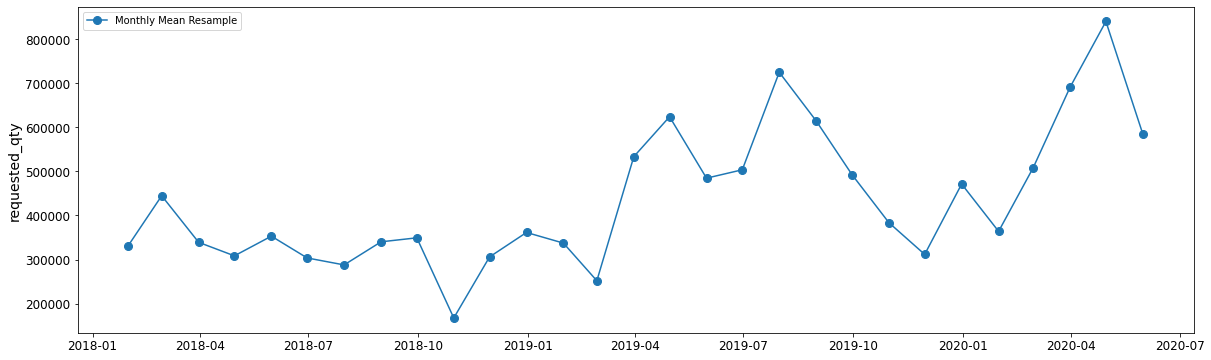

In [16]:
#Visualizing Time Series Average monthly demand data
y = train_data['requested_qty']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y.resample('M').mean(), marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('requested_qty')
ax.legend();

There are no distinguishable patterns appear when we plot the data.

The next step is to decompose the data to view more of the complexity behind the linear visualization.

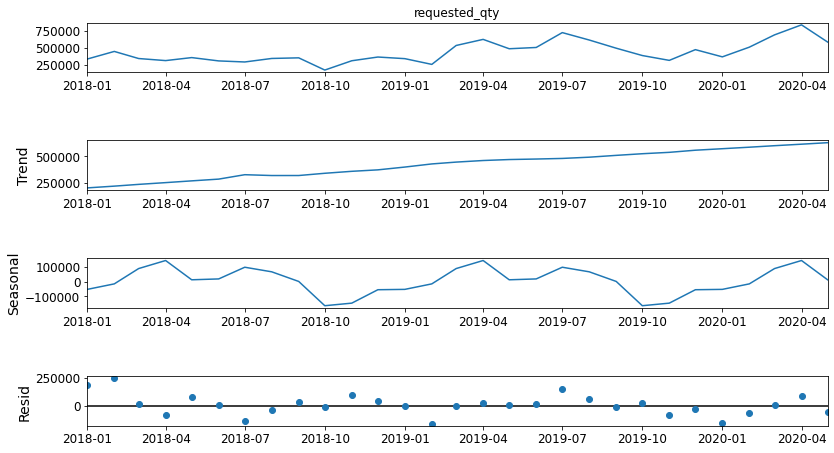

In [17]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(y)

After looking at the four pieces of decomposed graphs, ***we can tell that given sales dataset has an overall increasing trend as well as a yearly seasonality*** such as sales are always low at the end of the year. Depending on the components of the dataset like trend, seasonality, or cycles, the choice of model will be different.

Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity and mathematical transformations related to it to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test. 

In [18]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean12 = pd.Series(timeseries).rolling(window=12).mean()
    rolstd12 = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean12, label='rolling mean 12 month');
    ax.plot(rolstd12, label='rolling std (x10)');
    ax.legend()
    plt.show()


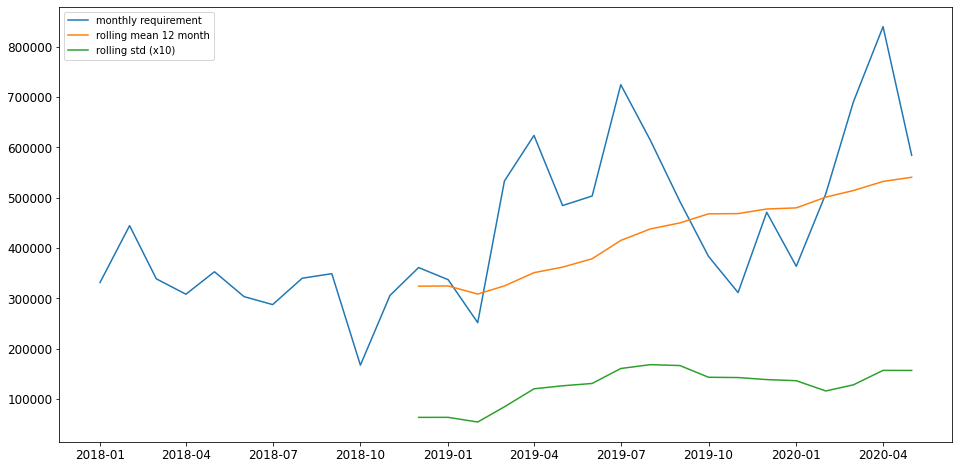

In [19]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'monthly requirement')

Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

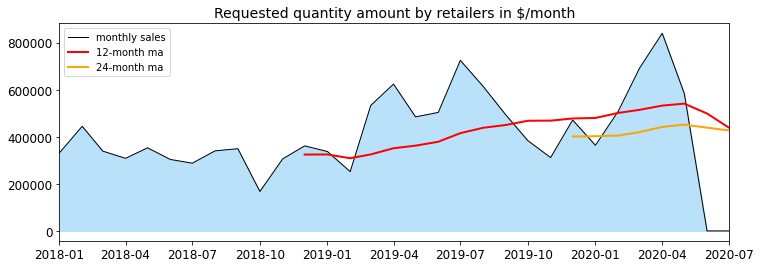

(0.4363164414665627, True)


In [20]:
# # Augmented Dickey-Fuller Test
def check_stationarity(dates, sales, title_string):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.title(title_string, fontsize=14)
    plt.plot(dates, sales, label='monthly sales', color="black", linewidth=1.0)
    ax.fill_between(dates, sales.min(), sales, color='#b9e1fa')
    ax.set_xlim([dates.min(),dates.max()])
    
    if dates.size > 12:
        ma = sales.rolling(window=12).mean()
        plt.plot(dates, ma, label='12-month ma', color="red", linewidth=2.0)
        ma = sales.rolling(window=24).mean()
        plt.plot(dates, ma, label='24-month ma', color="orange", linewidth=2.0)
    
    plt.legend()
    plt.show()
    
    sales = sales.dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sales))
    
train_df= train_df.iloc[1:33 , :]
df_sales = train_df['requested_qty']
df_dates = pd.to_datetime(train_df['Date']) 
title = "Requested quantity amount by retailers in $/month"
check_stationarity(df_dates, df_sales, title)

Looking at both the visualization and ADF test, we can tell that the given dataset is non-stationary. The reason is that it follows a clear upward trend. We also know that the time series has a seasonal component. Therefore, we need to define additional parameters to construct appropriate model.

To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use de-trending, differencing, and then a combination of the two.

**Step #4 Exemplary Differencing and Autocorrelation**

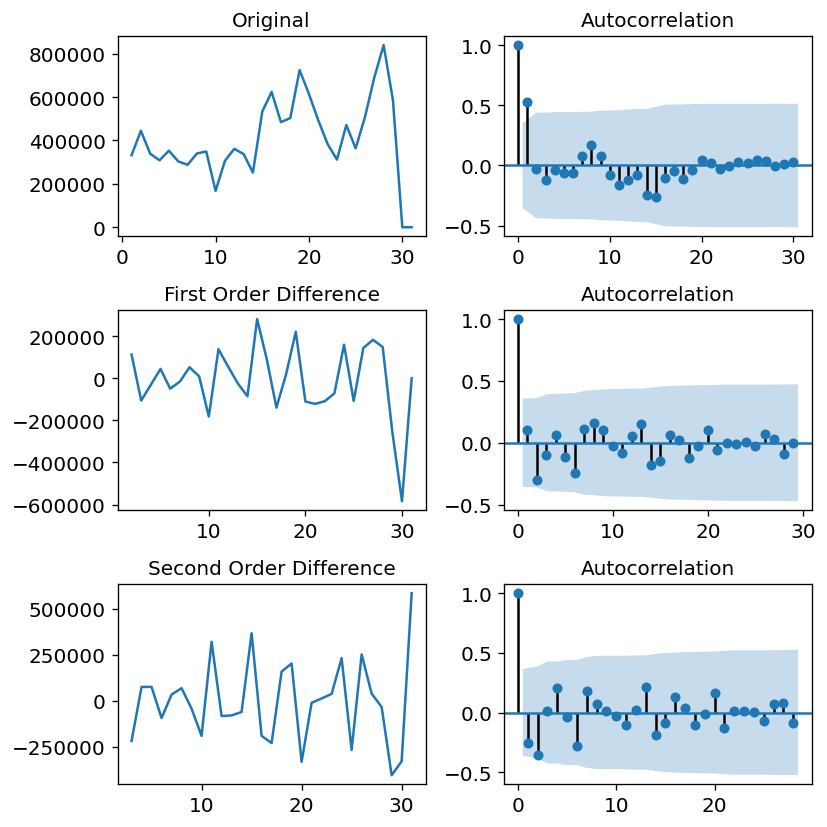

In [21]:
#Print the autocorrelation for the original time series and after the first and second-order differencing.
# 3.1 Non-seasonal part
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def auto_correlation(df, prefix, lags):
    plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
    fig, axes = plt.subplots(3,2, sharex=False)

    # First Difference
    axes[0, 0].plot(df)
    axes[0, 0].set_title('Original' + prefix)
    plot_acf(df_sales, lags=lags, ax=axes[0, 1])

    # First Difference
    df_first_diff = df.diff().dropna()
    axes[1, 0].plot(df_first_diff)
    axes[1, 0].set_title('First Order Difference' + prefix)
    plot_acf(df_first_diff, lags=lags - 1, ax=axes[1, 1])

    # Second Difference
    df_second_diff = df.diff().diff().dropna()
    axes[2, 0].plot(df_second_diff)
    axes[2, 0].set_title('Second Order Difference' + prefix)
    plot_acf(df_second_diff, lags=lags - 2, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()
    
auto_correlation(df_sales, '', 30)

The charts above show that the time series becomes stationary after second order differencing. However, we can see that the lag goes into the negative very quickly, which indicates overdifferencing.

Next, we perform the same procedure for the seasonal part of our time series.

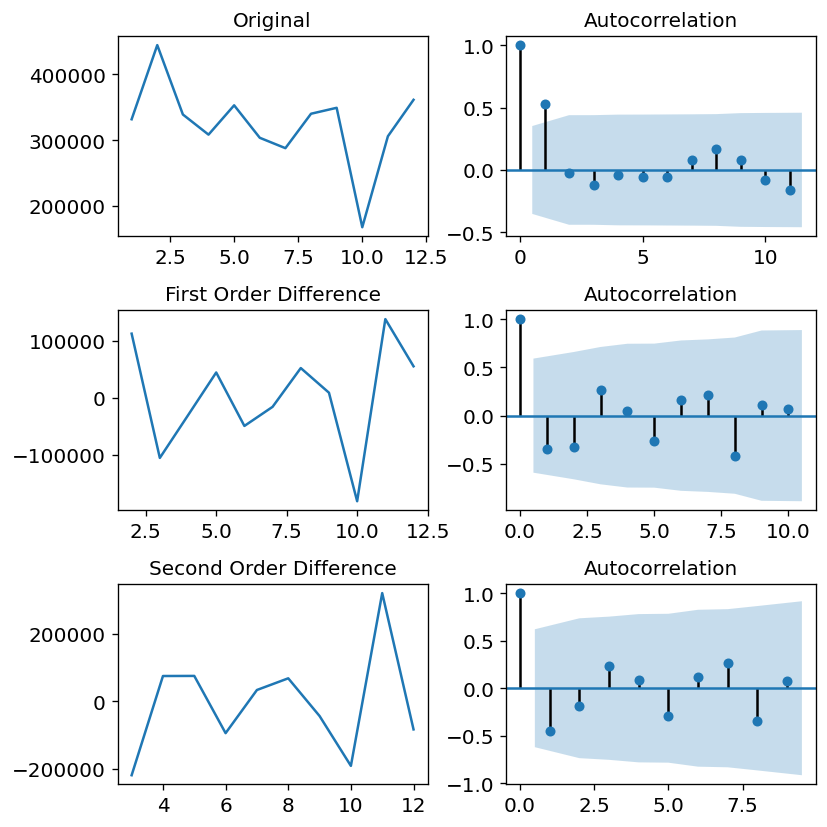

In [22]:
# 3.2 Seasonal part

# Reduce the timeframe to a single seasonal period
df_sales_s = df_sales[0:12]

# Autocorrelation for the seasonal part
auto_correlation(df_sales_s, '', 11)

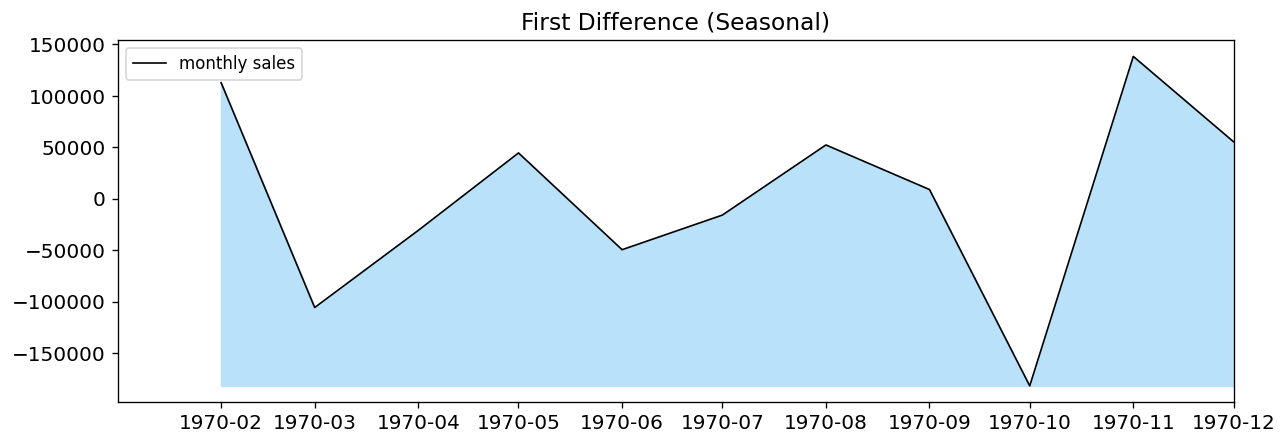

(0.23258026557050057, True)


In [23]:
# Check if the first difference of the seasonal period is stationary
df_dates_first_s = pd.date_range(df_sales_s.diff().iloc[1], periods=12, freq='MS') 

title = "First Difference (Seasonal)"
check_stationarity(df_dates_first_s, df_sales_s.diff(), title)

After first order differencing, the seasonal part of the time series is stationary. Concerning the autocorrelation plot, the plot shows that the values go into the negative but remain within acceptable boundaries. Second-order differencing does not seem to improve these values. We conclude that first-order differencing is a good choice for the D parameter.

In [24]:
y_to_train = y[:'2019-12-01'] # dataset to train
y_to_val = y['2020-01-01':'2020-05-01'] # last X months for test  
predict_date = len(y) - len(y[:'2020-01-01']) # the number of data points for the test set

**Step #5 Finding an Optimal Model**

**Model Building**

1. **Simple Exponential Smoothing (SES)**: Suitable for time series data without trend or seasonal components

In [25]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 239311.64
The Root Mean Squared Error of our forecasts with auto optimization is 248953.07


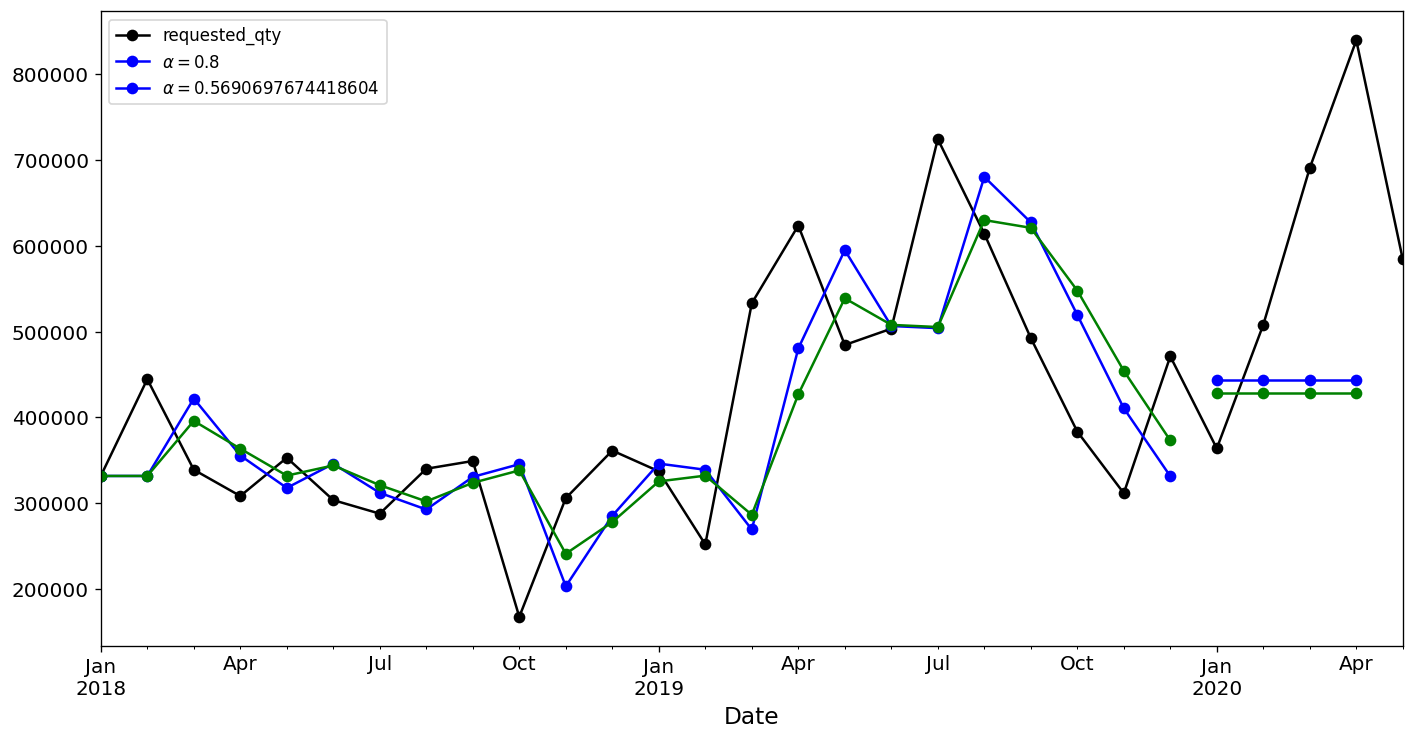

In [26]:
ses(y, y_to_train, y_to_val, 0.8, predict_date)

2. **Holt’s Linear Trend Method**: Suitable for time series data with a trend component but without a seasonal component.

In [27]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 289012.57
The Root Mean Squared Error of Holts Exponential trend 257123.09


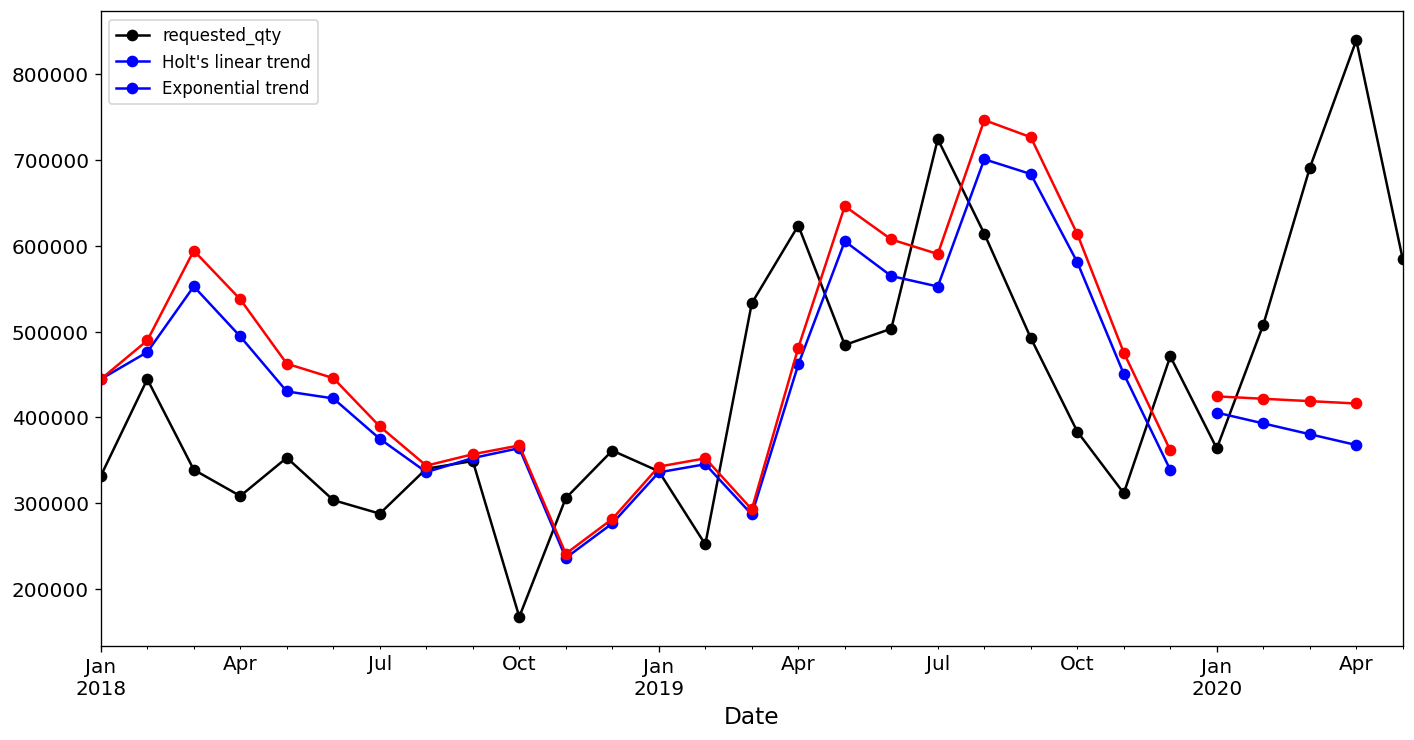

In [28]:
holt(y, y_to_train,y_to_val, 0.6, 0.2, predict_date)

3. **Holt-Winters’ Seasonal Method**: Suitable for time series data with trend and/or seasonal components.


In [29]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=12 and a Box-Cox transformation 122183.14
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=12 and a Box-Cox transformation 120807.87


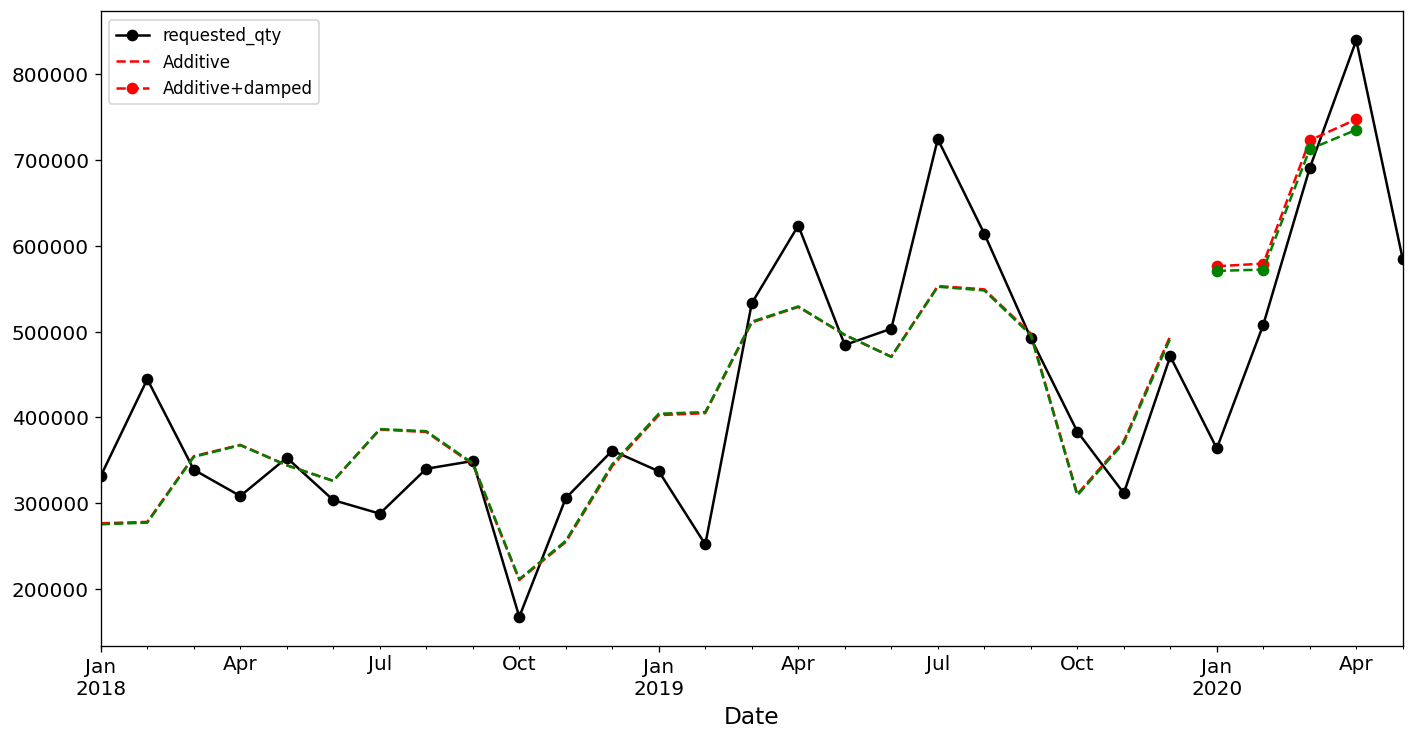

In [30]:
holt_win_sea(y, y_to_train,y_to_val,'additive',12, predict_date)

The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far.

4. **SARIMA**: Suitable for time series data with trend and/or seasonal components.

Next, we auto-fit an ARIMA model to our time series. 

Once we have created the train and test data sets, we can configure the parameters for the auto_arima stepwise optimization. By setting max_d = 1, we tell the model to test no-differencing and first-order differencing. Also, we set max_p and max_q to 3.

To deal with the seasonality in our time series, we set the “seasonal” parameter to True and the “m” parameter to 12 data points. In this way, we turn our model into a SARIMA model that allows us to configure additional D, P, and Q parameters. We define a max value for Q and P of 3. Previously we have already seen that further differencing does not improve the stationarity. Therefore, we can set the value of D to 1.

After we have configured the parameters, next, we fit the model to the time series. The model will try to find the optimal parameters and choose the model with the least AIC.

In [31]:
# split into train and test
pred_periods = 5
split_number = df_sales.count() - pred_periods # corresponds to a prediction horizion  of 2,5 years
df_train = df_sales[:split_number]
df_test = df_sales[split_number:]

df_train_dates = df_dates[:split_number]
df_test_dates = df_dates[split_number:] 

In [32]:
# Auto_Arima
model_fit = pm.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=1, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=1, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                          stepwise=True)

# summarize the model characteristics
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=664.835, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=659.146, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=662.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=661.598, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=657.254, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=660.202, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=659.970, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=661.792, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=660.966, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=660.338, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=660.121, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.756 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 

In [33]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()


    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.684e+10    3.8e+09      4.431      0.000    9.39e+09    2.43e+10


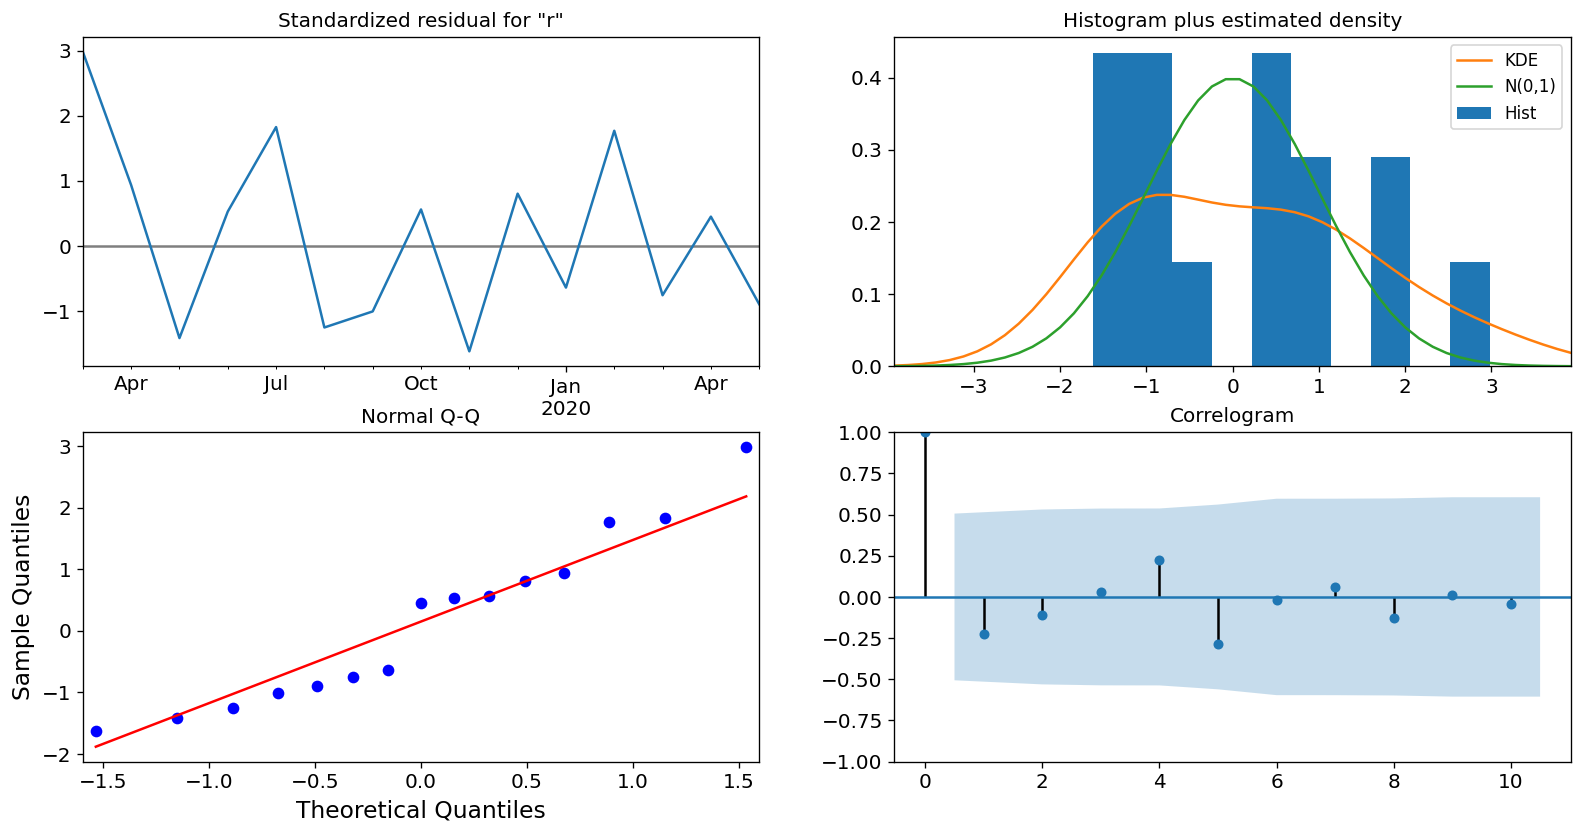

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 131305.13


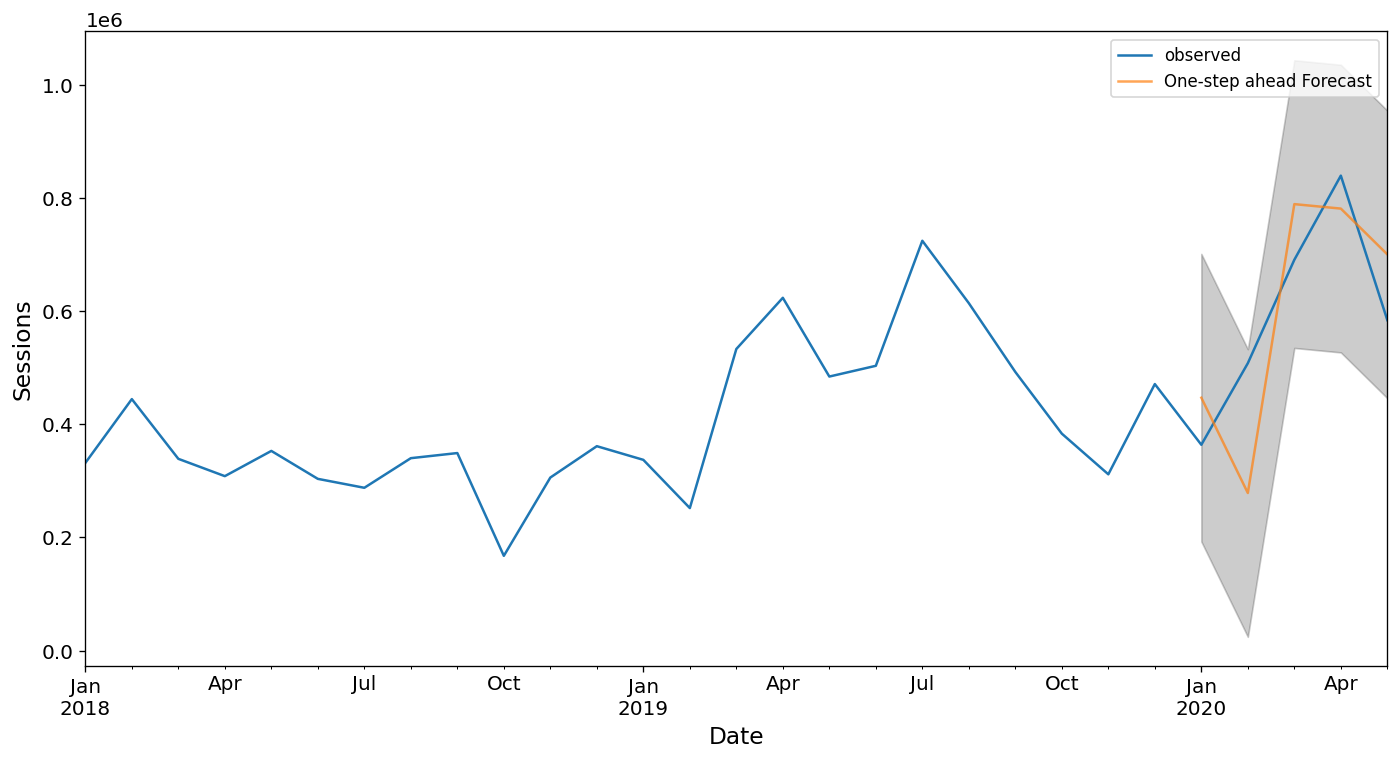

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 91659.99


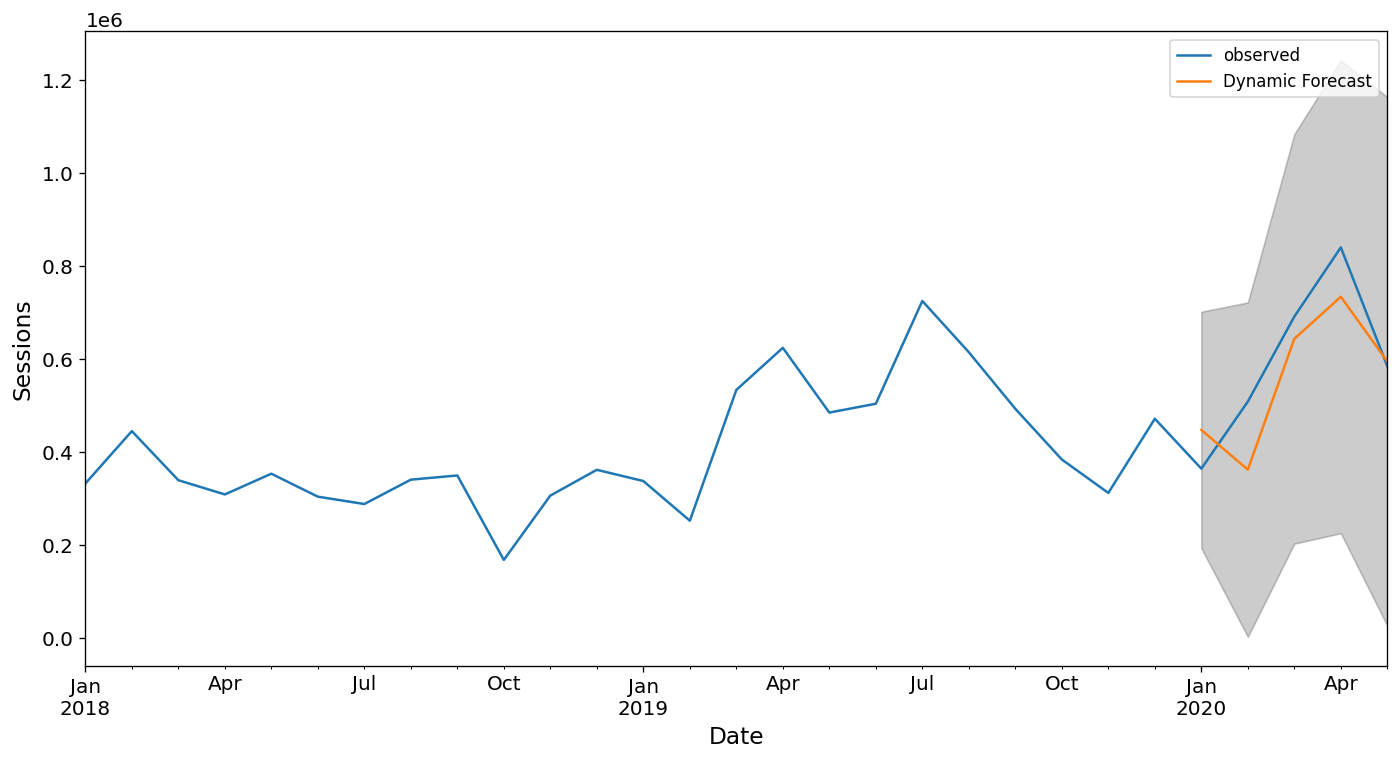

In [34]:
model = sarima_eva(y, (0, 1, 0), (0, 1, 0, 12), 12, '2020-01-01', y_to_val)

Compared with the results of all the previous models, we can be confident saying the SARIMA model best captures both the seasonality and trend of our dataset. Its forecasted results are closest to the actual quantity.

**Step #6 Generate and Visualize a Sales Forecast**

In [35]:
#Making Predictions
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

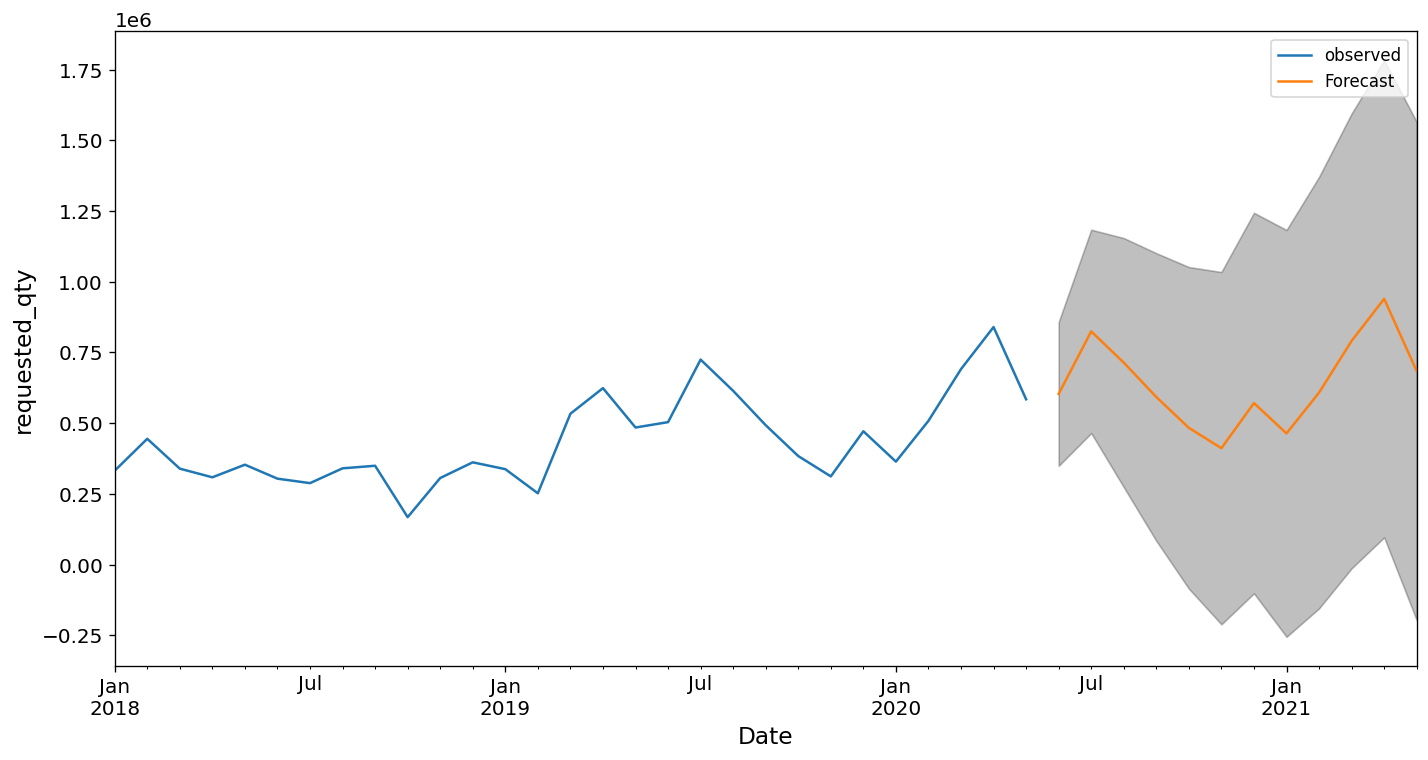

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-06-01,603256.28576164,348927.03594327,857585.53558000
1,2020-07-01,824352.57144586,464676.69704455,1184028.44584717


In [36]:
final_table = forecast(model, 12, y)
final_table.head(2)

**Conclusion**:

1. Four different models are tested out of which SARIMA performed best based on RMSE as performance metric as the given dataset contains yearly seasonality and an overall increasing trend.
2. There is a scope of multivariate time-series analysis, more feature engineering can be done and more models can be tested.
3. The predicted average monthly values for requested_qty in **June** and **July 2020** is **603,256** and **824,352** respectively.

**Notebook By: Manjeet Kaur**